In [1]:
!pip install pykakasi

In [3]:
import datetime
import numpy as np
import pandas as pd
import requests
import random
import time
import re
import jieba as jb
from bs4 import BeautifulSoup
from plotly.offline import plot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from wordcloud import WordCloud, STOPWORDS
import cv2, requests, jieba, pykakasi
from PIL import Image # 圖片轉array陣列
import wordcloud # 文字雲

# Insurance PTT crawler

In [4]:
# *** 選擇表格排序的依據 ***
while True: 
    try:
      print("請問要要怎麼排序表格?")
      sort_ = int(input('輸入1表示按照「日期」，輸入2表示按照「推廣數」:'))
      if sort_ == 1:
        sort_index = 'date'
        print("您選擇的排序方式是「日期」")
        break
      elif sort_ == 2:
        sort_index = 'push_num'
        print("您選擇的排序方式是「推廣數」")
        break
      else:
        print("輸入錯誤！")
    except:
        print("輸入錯誤！")

請問要要怎麼排序表格?
輸入1表示按照「日期」，輸入2表示按照「推廣數」:1
您選擇的排序方式是「日期」


In [5]:
# *** 選擇從哪天開始爬取文章 ***
while True: 
    try:
        print("請問要從哪一天開始抓取保險版一週的文章?")
        year = int(input('年(Year):'))
        month = int(input('月(month):'))
        day = int(input('日(day):'))
        datetime_date = datetime.date(year, month, day)
        break
    except:
        print("請輸入正確的年份、月份、日期")

# 為期一週
date_range = []
for i in range(7):
    date = (datetime_date - datetime.timedelta(days=i)).strftime('%m/%d').lstrip('0')
    date_range.append(date)
    
print("您選擇的日期範圍為",date_range)

請問要從哪一天開始抓取保險版一週的文章?
年(Year):2021
月(month):12
日(day):15
您選擇的日期範圍為 ['12/15', '12/14', '12/13', '12/12', '12/11', '12/10', '12/09']


In [6]:
def get_ppt_page(url):
    resp = requests.get(url=url)
    if resp.status_code != 200:
        print('Invalid url:', resp.url)
        return None
    else:
        return resp.text

In [7]:
def get_pageinfo(resdata,domain_url):
    soup = BeautifulSoup(resdata, 'html5lib')
    # 取得上一頁按鈕
    paging_div = soup.find('div', 'btn-group btn-group-paging')
    prev_url = paging_div.find_all('a')[1]['href']
    
    # 儲存取得的文章資料<div class="r-ent"></div>
    pptdata = []  
    date_divs = soup.find_all('div', 'r-ent')
    
    num = 0
    whether_prev = True
    for k in date_divs:
        # 判斷文章是否在一週內發佈
        week_date = k.find('div', 'date').text.strip() in date_range
        
        # 代表最早的日期，就不符合條件，所以不用下一頁
        if num == 0:
            if week_date == False:
                whether_prev = False
        # 一周內發布       
        if week_date:
            # 發布日期
            post_date = k.find('div', 'date').text.strip()
            #print("發布日期",post_date)
            
            # 推文數
            push_count = k.find('div', 'nrec').text
            push_num = 0
            if push_count:
                try:
                    push_num = int(push_count)  
                except ValueError:
                    # 若轉換失敗，可能是'爆'或 'X1', 'X2'
                    if push_count == '爆':
                        push_num = 100
                    elif push_count.startswith('X'):
                        push_num = -100
                    else:
                        push_num = 0
            #print("推文數",push_num)
            
            # 有超連結，代表文章存在
            if k.find('a'): 
                # 文章標題
                title = k.find('a').text
                #print("標題",title)
                # 文章連結
                href = k.find('a')['href']
                #print("標題連結",domain_url+href)
                
                pptdata.append({
                    'date': post_date,
                    'push_num': push_num,
                    'title': title,
                    'href': domain_url+href
                })
        
        #每做完一次，num+1
        num = num + 1 
    df = pd.DataFrame(pptdata, columns=['date','push_num', 'title', 'href'])
    
    return prev_url,df,whether_prev

#https://www.ptt.cc/bbs/Insurance/M.1620735794.A.AFE.html

In [8]:
if __name__ == '__main__':
    # *** 選擇保險版 ***
    domain_url = 'https://www.ptt.cc'
    Insurance = '/bbs/Insurance/index.html'
    # 第一頁
    web_url = domain_url + Insurance
    #print(web_url)
    ppt_page = get_ppt_page(web_url)
    prev_href,df,whether_prev = get_pageinfo(ppt_page,domain_url) 
    
    # 往前一頁
    while whether_prev:
        web_url = domain_url+prev_href
        #print(web_url)
        ppt_page = get_ppt_page(web_url)
        prev_href,df_next,whether_prev = get_pageinfo(ppt_page,domain_url) 
        df = pd.concat([df,df_next])
   
    df.index = df[sort_index]
    df = df.sort_index(ascending=False)
    df = df.reset_index(drop=True)

In [9]:
df.head(5)

,date,push_num,title,href
0,12/15,0,[險種] 實支實付，意外，醫療,https://www.ptt.cc/bbs/Insurance/M.1639571908....
1,12/15,0,[險種] 34歲女 既有保單檢視及新保單規劃,https://www.ptt.cc/bbs/Insurance/M.1639501250....
2,12/15,4,[討論] 保經 公X vsX律哪個好,https://www.ptt.cc/bbs/Insurance/M.1639564404....
3,12/15,0,[理賠] 興農生活大師終身保險計畫B,https://www.ptt.cc/bbs/Insurance/M.1639558642....
4,12/15,0,[險種] 33歲男既有保單檢視及規劃,https://www.ptt.cc/bbs/Insurance/M.1639552854....


# WordClouds

In [10]:
# 定義刪除除字母漢字以外的所有符號的函數
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

In [11]:
# 加载停用词
def stopwordslist():  
    filepath = "/content/drive/MyDrive/國泰實習/國泰ptt爬蟲/Ref/NEW_ChineseStopWords.txt"
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

In [12]:
# 刪除除漢字以外的所有符號
df["clean_title"] = df["title"].apply(remove_punctuation)

In [13]:
# 刪除停用詞
stopwords_list = stopwordslist()
df["cut_title"] = df["clean_title"].apply(lambda x: ",".join([w for w in list(jb.cut(x)) if w not in stopwords_list]))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.112 seconds.
Prefix dict has been built successfully.


In [14]:
# 刪除自訂詞
delete_word = ['保險','保單','歲']
df["cut_title"] = df["cut_title"].apply(lambda x: ",".join([w for w in list(jb.cut(x)) if w not in delete_word]))

In [15]:
def word_dict(df):
    wds = ''
    x = df["cut_title"].values

    # 總詞彙矩陣
    all_word = []
    for i in range(len(df)):
        i_word = x[i].split(",")
        all_word = np.hstack((all_word,i_word))

    # 總詞彙txt
    wds =",".join(all_word)

    # 詞彙字典與頻率
    dic={}
    for word in all_word:
        if word not in dic:
            dic[word] = 1
        else:
            dic[word] = dic[word] + 1  

    # 總詞彙表
    keyword = pd.DataFrame(list(dic.items()), columns=['Keyword', 'Frequency'])
    keyword.index = keyword['Frequency']
    keyword = keyword.sort_index(ascending=False)
    keyword = keyword.reset_index(drop=True)

    return wds, keyword

In [16]:
wds, keyword = word_dict(df)

In [17]:
# 以表格顯示關鍵詞
keyword

,Keyword,Frequency
0,,358
1,險種,20
2,規劃,14
3,女,13
4,檢視,8
...,...,...
82,乙式,1
83,教,1
84,丙式,1
85,富邦,1


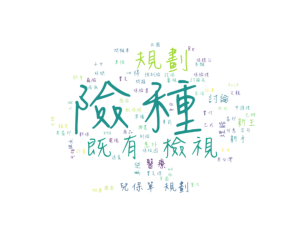

In [18]:
# 以文字雲顯示關鍵詞
pic = '/content/drive/MyDrive/國泰實習/國泰ptt爬蟲/Ref/cathay tree.png'
fntName = '/content/drive/MyDrive/國泰實習/國泰ptt爬蟲/Ref/華康秀風體.TTF'
img = cv2.imread(pic)
wc = WordCloud(background_color="white", font_path=fntName,stopwords=set(STOPWORDS), max_words=100,max_font_size=200,mask=img)
wc.generate(wds)
plt.axis(False)
_=plt.imshow(wc)

In [19]:
wc.to_file('/content/drive/MyDrive/國泰實習/國泰ptt爬蟲/test.jpg')